In [31]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3 as sq3

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Goal
The main goal of this project is to estimate predict the chance of a patient having a liver disease based on some feature (a binary classification problem). A side the prediction, we will like to know what features play a significant role in the prediction, in order to inform the doctor on how to advice his or her patients to prevent or lessen the chances of getting the liver disease.

## Data

This is a medical data with eleven features: 
* age of patient
* Gender
* Albumin: Amount of protein synthesized by the liver
* Total Bilirubin: The total amount of bilirubin in the blood, a yellow pigment produced by the breakdown of red blood cells.
* Direct Bilirubin: The direct fraction of bilirubin, specifically associated with liver function.
* SGPT (Serum Glutamic Pyruvic Transaminase): An enzyme indicating liver health; elevated levels may suggest liver damage.
* A/G Ratio: The ratio of albumin to globulins, providing insights into liver and kidney function.
* Total Proteins: The total amount of proteins in the blood, including albumin and globulins.
* SGOT (Serum Glutamic Oxaloacetic Transaminase): Another liver enzyme reflecting liver function; elevated levels may indicate liver problems.

* Alkphos (Alkaline Phosphatase): An enzyme associated with the biliary system; elevated levels may indicate liver or bone issues.

## Exploratory Data Analysis/ data cleaning and feature engineering
The steps beow are all the steps taken to understand the data:
1. Size/shape of the data
2. Data types by feature columns
3. Determine which columns are categorical (nominal or ordinal) and numeric
4. Identify the target column and find the distribution of the classes to check if it is unbalanced or not
5. Check for duplicates, missing values and correlations (to deternmine which features are important and also to prevent multicolinearity)
6. Encode the categorical features using one-hot encoding 
7. Perform a feature scaling so that all features on the same scale. This is particulary for KNN models and the essence of this step is to step up the learning rate of the model





In [3]:
data = pd.read_csv("Indian Liver Patient Dataset (ILPD).csv")

data.dtypes.value_counts()

float64    5
int64      5
object     1
dtype: int64

In [4]:
data.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [5]:
print("##" * 30)
print(" " * 17, "Data set Information")
print("##" * 30)
data.info()

############################################################
                  Data set Information
############################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        583 non-null    int64  
 1   Gender     583 non-null    object 
 2   TB         583 non-null    float64
 3   DB         583 non-null    float64
 4   Alkphos    583 non-null    int64  
 5   Sgpt       583 non-null    int64  
 6   Sgot       583 non-null    int64  
 7   TP         583 non-null    float64
 8   ALB        583 non-null    float64
 9   A/G Ratio  579 non-null    float64
 10  Selector   583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


The following observations are made from using the `info()` function on the dataframe:

* It is clear that the data has $583$ elements or rows and $11$ columns. 
* The column A/G Ratio has some missing elements.
* All columns except the Selector column are of numeric type (i.e.either int ot float)
* 

Next, we separate the categorical and numerical variables to allow us to encode their values:

In [6]:
# select all column names
all_columns = data.columns.to_list()
print("##" * 30)
print(" " * 17, "All Columns in Data")
print("##" * 30)
print(all_columns)

############################################################
                  All Columns in Data
############################################################
['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G Ratio', 'Selector']


In [7]:
numeric_variables = data.select_dtypes(include=[int, float]).columns.to_list()
print("##" * 30)
print(" " * 17, "Numeric Columns in Data")
print("##" * 30)
print(numeric_variables)

############################################################
                  Numeric Columns in Data
############################################################
['Age', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G Ratio', 'Selector']


In [8]:
categorical_variables = list(set(all_columns) - set(numeric_variables))
print("##" * 30)
print(" " * 17, "Categorical Columns in Data")
print("##" * 30)
print(categorical_variables)

############################################################
                  Categorical Columns in Data
############################################################
['Gender']


Below, we use the `describe()` function on the numeric variable columns to the get a brief statistics on the data. It is clear that the data is not scaled as the `min` and `max` values are far apart. This requires that in the preprocessing of the data for the model training, we can do some feature scaling to speed up the learning rate during the training. 

`value_counts` is applied to categorical variables columns to obtain the unique elements in their columns. Here we have two classes: Male and Female which appears 

In [9]:
data[numeric_variables].describe()

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


In [10]:
data[categorical_variables].value_counts()

Gender
Male      441
Female    142
dtype: int64

The target column, `Selector` is numeric and has only two unique values (using `unique()` gives the unique values and `nunique()` gives the number of unique values): $1$ and $2$ and the target has an unbalanced class and this should inform the choice of performance metrics used in evaluating the training models (accuracy is not a good choice as the target is unbalance). See below:

In [11]:
target = "Selector"
print("Unique entries for the target: \n", data[target].unique())
print(" ")
print("Proportion of the target entries: \n",
      data[target].value_counts(normalize=True))

Unique entries for the target: 
 [1 2]
 
Proportion of the target entries: 
 1    0.713551
2    0.286449
Name: Selector, dtype: float64


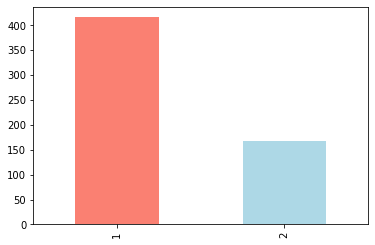

In [12]:
data[target].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

In [13]:
df_uniques = data.nunique()
print("##" * 30)
print(" " * 17, "Number of unique entries for all coulmns:")
print("##" * 30)
print(df_uniques)

############################################################
                  Number of unique entries for all coulmns:
############################################################
Age           72
Gender         2
TB           113
DB            80
Alkphos      263
Sgpt         152
Sgot         177
TP            58
ALB           40
A/G Ratio     69
Selector       2
dtype: int64


To perform `one-hot-encoding` on the nominal categorical variables, the data type needs to prefarabley be a string and so the need to map the int to string types as done  just below.

In [14]:
mapping_selector = {1: "liver disease", 2: "no liver disease"}

data["Selector"] = data["Selector"].map(mapping_selector)
# data['Selector'] = data.Selector.replace(1,"liver disease").replace(2,"no liver disease").astype(np.int)


print(data["Selector"].unique())

['liver disease' 'no liver disease']


In [15]:
data.head(10)

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,liver disease
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,liver disease
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,liver disease
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,liver disease
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,liver disease
5,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,liver disease
6,26,Female,0.9,0.2,154,16,12,7.0,3.5,1.00,liver disease
7,29,Female,0.9,0.3,202,14,11,6.7,3.6,1.10,liver disease
8,17,Male,0.9,0.3,202,22,19,7.4,4.1,1.20,no liver disease
9,55,Male,0.7,0.2,290,53,58,6.8,3.4,1.00,liver disease


## Duplicates
To remove any instability of our model due to over-represenation, we needd to remove duplicates (13 in this case) in our data using `drop_duplicates(inplace=True)`

In [16]:
print("##" * 30)
print(" " * 17, "Number of dupicated entries:")
print("##" * 30)
print(data.duplicated().sum())

############################################################
                  Number of dupicated entries:
############################################################
13


In [17]:
# duplicates removed from the original dataset
data.drop_duplicates(inplace=True)

In [18]:
print("##" * 30)
print(" " * 17, "Number of dupicated entries:")
print("##" * 30)
print(data.duplicated().sum())

############################################################
                  Number of dupicated entries:
############################################################
0


## Missing Data
Handle missing data in this case by removing the rows with the missing data (not the column) by using `dropna(axis=0)`. I have written a function to perform this this task:


```python
def handle_missing_data(data, strategy="mean", columns=None):
    """Handle missing data by filling or dropping.
    values = {'col1': 0, 'col2': 1, 'col3': 2 }
    df.fillna(value=values)
    """
    # to do: add some condition to determine the data type of the column
    if strategy == "mean":
        my_imputer = SimpleImputer(strategy="mean")
        data = my_imputer.fit_transform(data)

    elif strategy == "median":
        my_imputer = SimpleImputer(strategy="median")
        data = my_imputer.fit_transform(data)

    elif strategy == "drop":
        if columns:
            # drop columns with missing values
            data.dropna(axis=1, inplace=True)
        else:
            # drop rows with missing values
            data.dropna(axis=0, inplace=True)
    else:
        raise ValueError("Invalid strategy. Use 'mean', 'median', or 'drop'")
    return data
```


In [19]:
print("##" * 30)
print(" " * 17, "Number of missing entries:")
print("##" * 30)
print(data.isnull().sum())

############################################################
                  Number of missing entries:
############################################################
Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    4
Selector     0
dtype: int64


In [20]:
data.dropna(axis=0, inplace=True)
print("##" * 30)
print(" " * 17, "Number of missing entries:")
print("##" * 30)
print(data.isnull().sum())

############################################################
                  Number of missing entries:
############################################################
Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    0
Selector     0
dtype: int64


## One-hot-encoding

In [21]:
# drop_fist= True to prevent multicollinearity
data_encoded = pd.get_dummies(
    data, columns=["Gender", "Selector"], drop_first=True)

data_encoded.head(10)

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Gender_Male,Selector_no liver disease
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,0,0
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,0
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,0
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,0
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,0
5,46,1.8,0.7,208,19,14,7.6,4.4,1.30,1,0
6,26,0.9,0.2,154,16,12,7.0,3.5,1.00,0,0
7,29,0.9,0.3,202,14,11,6.7,3.6,1.10,0,0
8,17,0.9,0.3,202,22,19,7.4,4.1,1.20,1,1
9,55,0.7,0.2,290,53,58,6.8,3.4,1.00,1,0


In [22]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        566 non-null    int64  
 1   TB                         566 non-null    float64
 2   DB                         566 non-null    float64
 3   Alkphos                    566 non-null    int64  
 4   Sgpt                       566 non-null    int64  
 5   Sgot                       566 non-null    int64  
 6   TP                         566 non-null    float64
 7   ALB                        566 non-null    float64
 8   A/G Ratio                  566 non-null    float64
 9   Gender_Male                566 non-null    uint8  
 10  Selector_no liver disease  566 non-null    uint8  
dtypes: float64(5), int64(4), uint8(2)
memory usage: 45.3 KB


In [23]:
data_encoded.describe()

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Gender_Male,Selector_no liver disease
count,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000
mean,44.886926,3.338869,1.505830,292.567138,80.143110,109.892226,6.494876,3.145583,0.948004,0.756184,0.286219
std,16.274893,6.286728,2.841485,245.936559,182.044881,291.841897,1.087512,0.795745,0.319635,0.429763,0.452393
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000,0.000000
25%,33.000000,0.800000,0.200000,176.000000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000,0.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,41.000000,6.600000,3.100000,0.950000,1.000000,0.000000
75%,58.000000,2.600000,1.300000,298.000000,60.750000,87.000000,7.200000,3.800000,1.100000,1.000000,1.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000,1.000000


## Split data into predictor and target variables

In [24]:
target = "Selector_no liver disease"
X = data_encoded.drop(target, axis=1)
y = data_encoded[target]

# Correlation and Multicollinearity

A larger correlation between the a feature an a target means the the feature has a greater influence on the prediction. When independent variables have a high correlations, this causes that the model results are unstable, since the models overfit and making it difficlt to choose the most signficant features or variables. This called `multicollinearity`. Using `sns.pairplot` we can immediately visualize the relationship between all feature variables. Looking at our pairplot, we see somekind of separation between the people with and without liver disease. This means, there is a chance we can build a classifier to separate the two classes. We see a large correlation between DB and TB, Sgot and Sgpt, TP and ALB  and A/G ratio and ALB. At this point we will not do feature elimination but we will rely on regularization to reduce their effects on prediction.



In [25]:
# correlation between the freatures and the target. None of the features correlates with the target
correlations = X.corrwith(y)
correlations.sort_values(inplace=True)
correlations

DB            -0.250926
TB            -0.224467
Alkphos       -0.186057
Sgpt          -0.161617
Sgot          -0.151009
Age           -0.133821
Gender_Male   -0.077396
TP             0.036443
ALB            0.165273
A/G Ratio      0.171402
dtype: float64

[(-0.3, 0.3), Text(0, 0.5, 'correlation with target')]

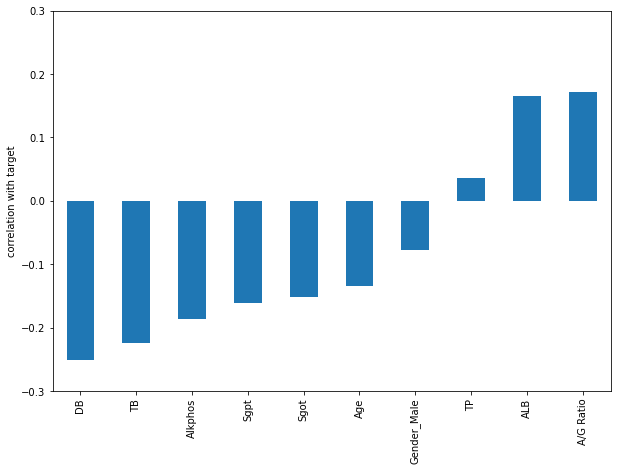

In [26]:
# this gives a better way to visualize the correlation between each feature and target
ax = correlations.plot(kind="bar", figsize=(10, 7))
ax.set(ylim=[-0.3, 0.3], ylabel="correlation with target")

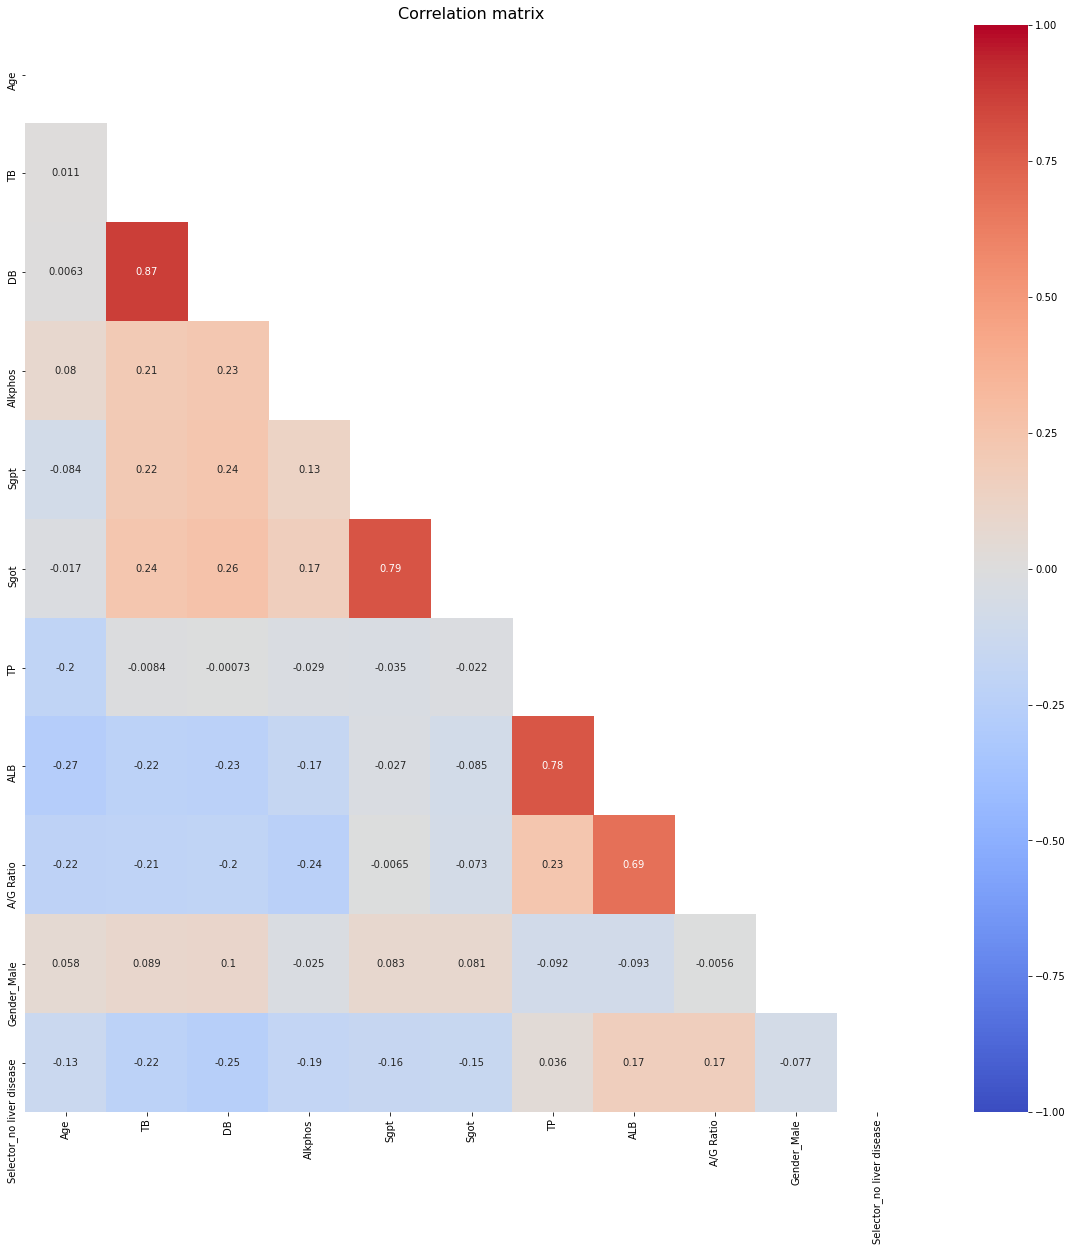

In [27]:
# correlation matrix for all the data is plotted below
corr = data_encoded.corr()
plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, mask=mask)
plt.title("Correlation matrix", fontsize=16)
plt.show()

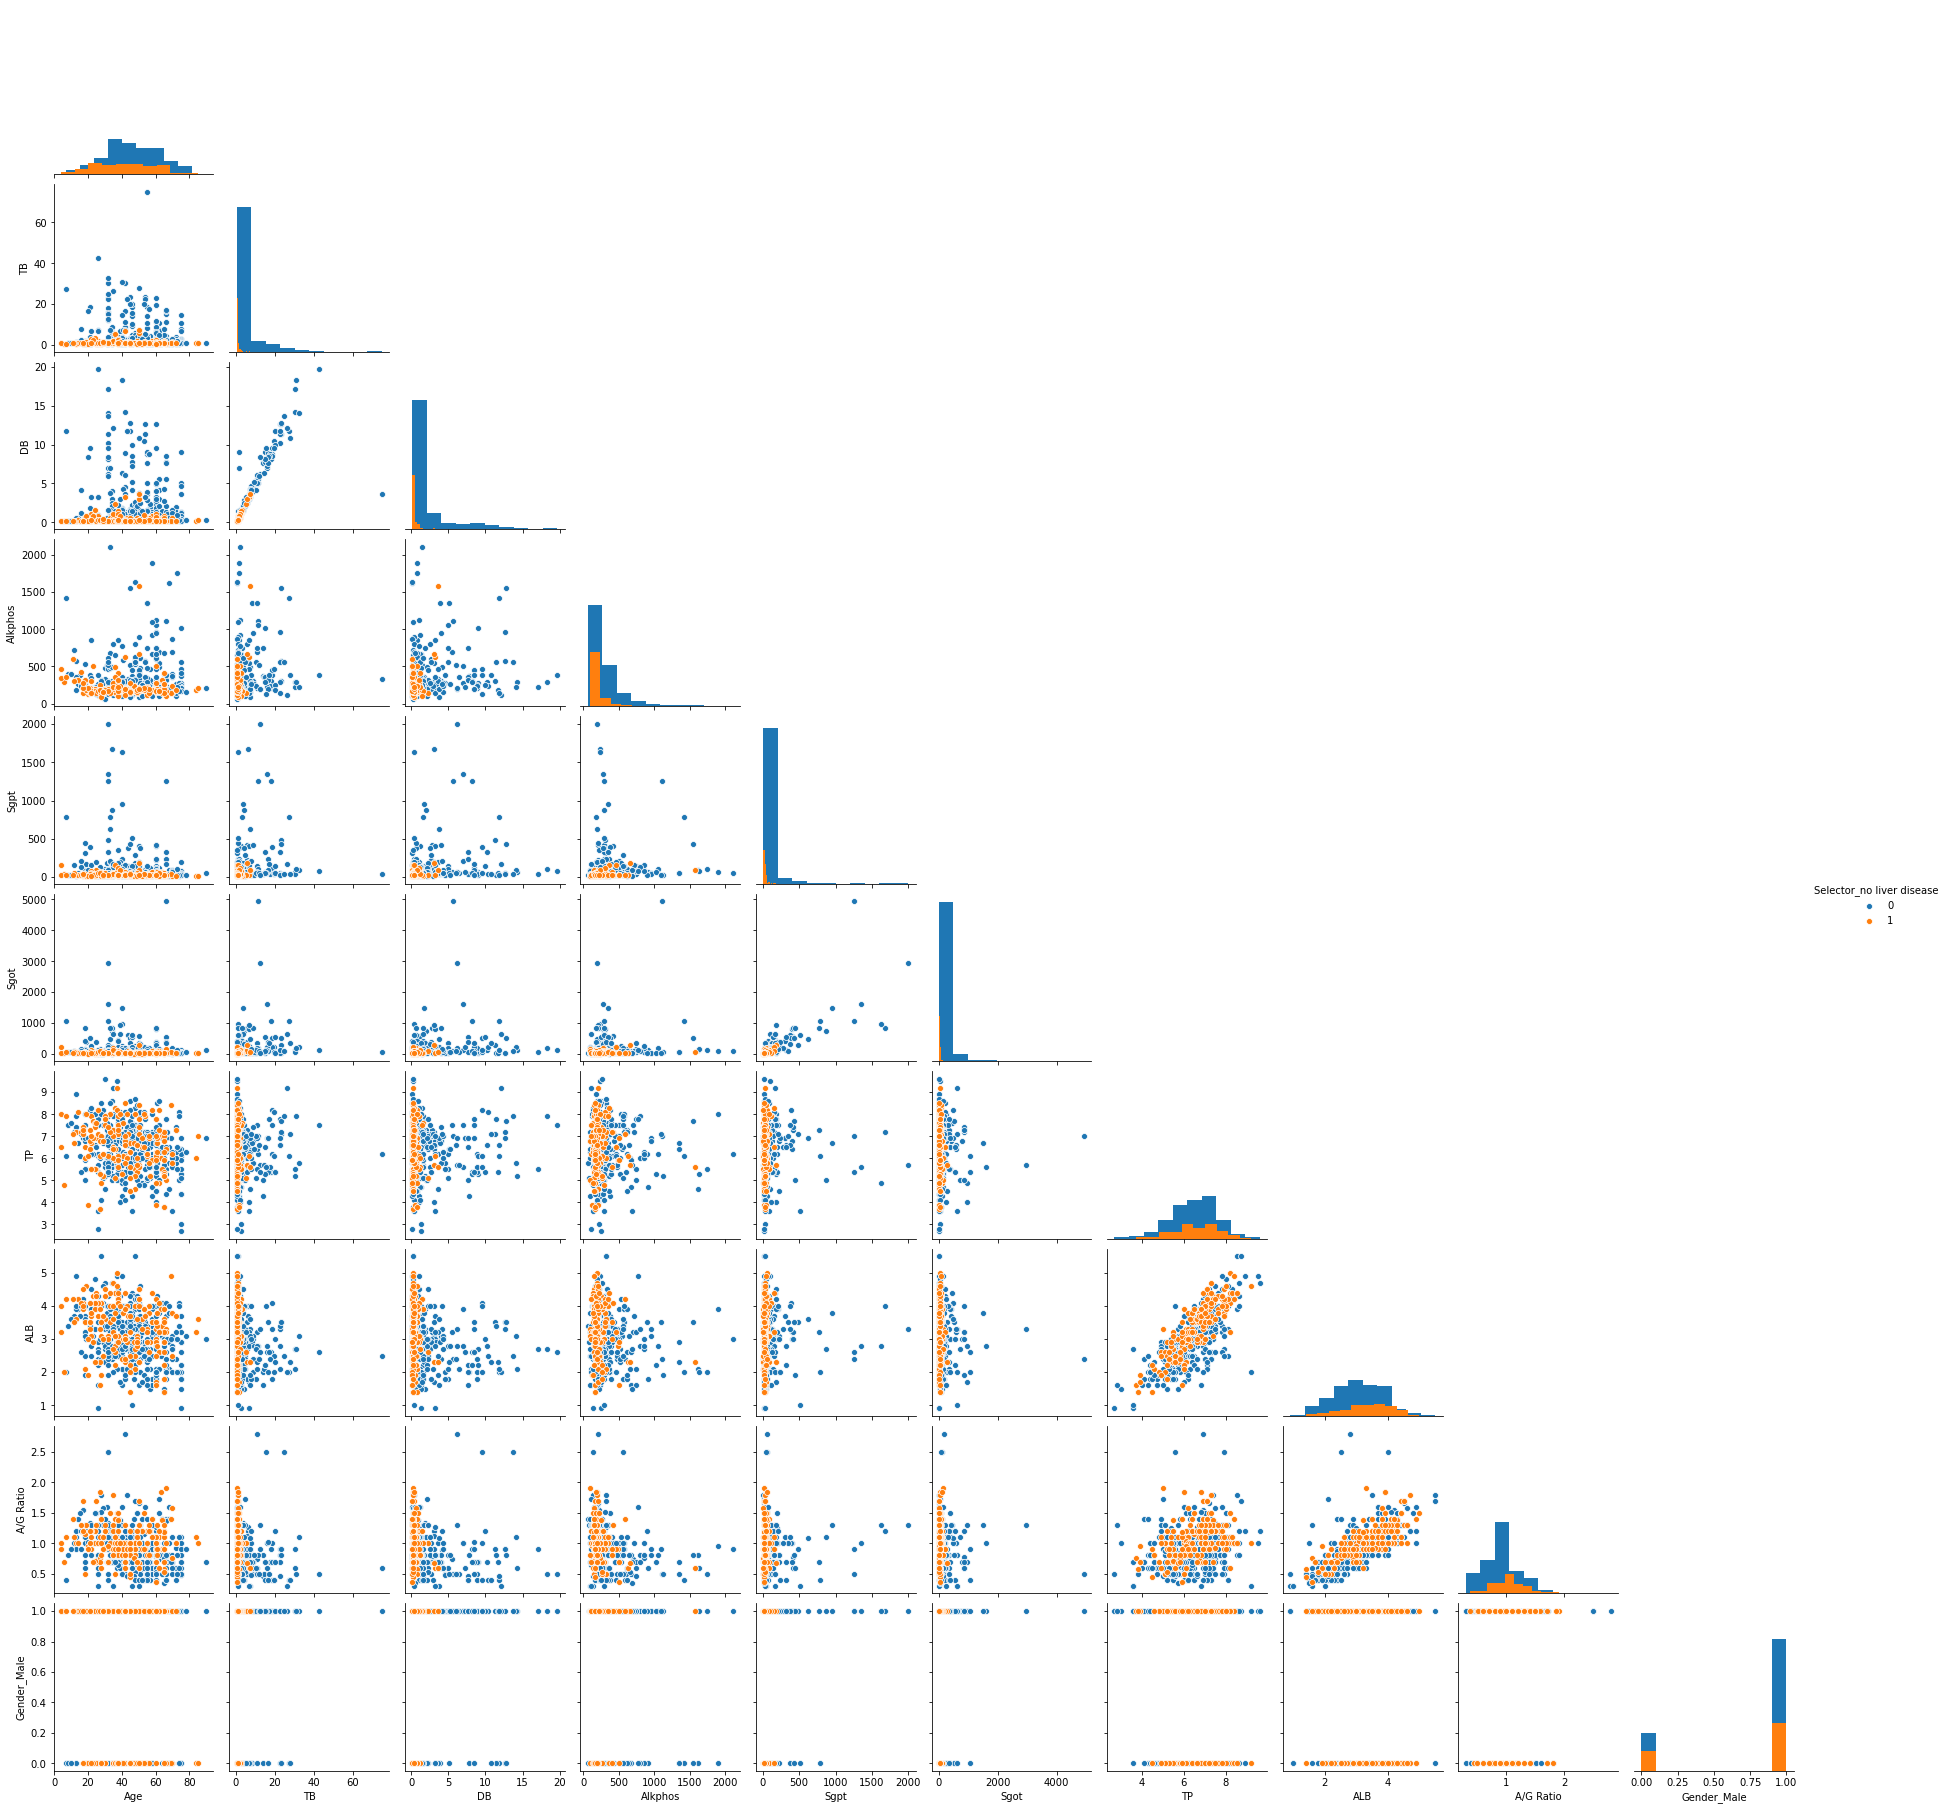

In [28]:
sns.pairplot(
    data_encoded,
    hue="Selector_no liver disease",
    diag_kind="hist",
    corner=True,
    kind="scatter",
)

# Feature Scaling

Here, the data is split into traing and test sets for the sole purpose of evaluating the model. Each of these features are scaled so that all the features are on the same scale. For this work, `MinMaxScaler` from `sklearn.preprocessing` is used.

In [34]:
# Get the split indexes
# This creates a generator to ensure equal proportions in both train and test sets and generally ussed for a skewed data
# strat_shuf_split = StratifiedShuffleSplit(
#     n_splits=1, test_size=0.3, random_state=42)

# Get the index values from the generator
# train_idx, test_idx = next(strat_shuf_split.split(X, y))

# print(train_idx)
# Create the data sets
# X_train = X.iloc[train_idx, :]
# y_train = y.iloc[train_idx]

# X_test = X.iloc[test_idx, :]
# y_test = y.iloc[test_idx]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("X_train shape: ", X_train.shape)
print(" ")

print("y_train shape: ", y_train.shape)
print(" ")

print("X_test shape: ", X_test.shape)
print(" ")

print("y_test shape: ", y_test.shape)
print(" ")

print("proportions of y_train: \n", y_train.value_counts(normalize=True))
print(" ")

print("proportions of y_test: \n", y_test.value_counts(normalize=True))

X_train shape:  (396, 10)
 
y_train shape:  (396,)
 
X_test shape:  (170, 10)
 
y_test shape:  (170,)
 
proportions of y_train: 
 0    0.714646
1    0.285354
Name: Selector_no liver disease, dtype: float64
 
proportions of y_test: 
 0    0.711765
1    0.288235
Name: Selector_no liver disease, dtype: float64


In [35]:
scaler = StandardScaler()  # MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

## Model Training and Choice of Model
Here, different classification models are used and for each model. Hyperparameter fine tunning is done to select the best parameters for each model (using `GridSearcgCV` from sklear). The different models are then compared to choose the best model. 

The choice of a model is relevant for the goal of a project: either prediction or interpretation (considered both intrinsic models like decision trees, KNN, etc and post-hoc models like svm, ensemble tress, etc). It is also relevant as the different models have their pros and cons in terms of how fast it trains or fits, memory intensiveness (usage line KNN models that requires a lot of memory and slow at predictions but fast at training).

The models considered are Logistic regression, K-nearest neighbor, support vector machine, decision tree, bagging, random forest, extra random trees, AdaBoost, and Gradient Boosting. The choice of the best model, in this work, is the model with the best values for the recall, f1-score and AUC scores and also has a higher interpretability. Below is the performance of various moedls after a gridsearch cross-validation method was applied.



In [36]:
## Logistic Regression

logreg = LogisticRegression(solver="liblinear")
parameters = [
    {
        "penalty": ["l1", "l2"],
        "C": [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100],
        "max_iter": [100, 150, 1000, 2500, 5000],
    },
]


grid_search_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=parameters,
    scoring="accuracy",
    cv=25,
    verbose=0,
    error_score="raise",
)

logreg = grid_search_logreg.fit(X_train_s, y_train)

# Make predictions on the test data
y_pred = grid_search_logreg.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)

print(
    "Best score (accuracy): \n",
    grid_search_logreg.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_logreg.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_logreg.best_estimator_.coef_,
    "\n",
)

Accuracy: 0.7294117647058823
Precision: 0.6
Recall: 0.1836734693877551
F1-Score: 0.28125
AUC: 0.5670433462641254
Best score (accuracy): 
 0.7218333333333333 
 
 Best hyperparameters: 
 {'C': 1, 'max_iter': 100, 'penalty': 'l1'} 
 
 Best coefficients: 
 [[-0.26615246 -0.07546883 -1.29067282 -0.13106589 -0.88224863 -0.68288161
  -0.32752442  0.30927306  0.         -0.06198449]] 



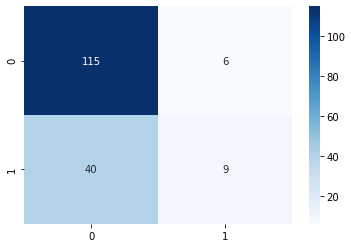

In [37]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
plt.show()

In [38]:
# KNN

cv = RepeatedStratifiedKFold(n_splits=15, n_repeats=5, random_state=1)

estimator_KNN = KNeighborsClassifier(algorithm="auto")
parameters_KNN = {
    "n_neighbors": (1, 10, 1),
    "leaf_size": (20, 40, 1),
    "p": (1, 2),
    "weights": ("uniform", "distance"),
    "metric": ("minkowski", "chebyshev"),
}

# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    n_jobs=-1,
    cv=25,
)

knn = grid_search_KNN.fit(X_train_s, y_train)

# Make predictions on the test data
y_pred = grid_search_KNN.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)

print(
    "Best score (accuracy): \n",
    grid_search_KNN.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_KNN.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_KNN.best_estimator_,
    "\n",
)

Accuracy: 0.6941176470588235
Precision: 0.4117647058823529
Recall: 0.14285714285714285
F1-Score: 0.21212121212121207
AUC: 0.5301062573789846
Best score (accuracy): 
 0.7093333333333334 
 
 Best hyperparameters: 
 {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 
 
 Best coefficients: 
 KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1) 



In [47]:
# SVM

model = SVC()


grid = [
    {
        "C": [0.1, 1, 10, 100],
        "gamma": [10, 2, 1, 0.1, 0.01],
        "kernel": ["rbf", "poly", "sigmoid"],
    }
]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

grid_search_SVC = GridSearchCV(
    estimator=model,
    param_grid=grid,
    n_jobs=-1,
    cv=15,
    error_score=0,
)

svc = grid_search_SVC.fit(X_train_s, y_train)

# Make predictions on the test data
y_pred = grid_search_SVC.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)

print(
    "Best score (precision): \n",
    grid_search_SVC.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_SVC.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_SVC.best_estimator_,
    "\n",
)

Accuracy: 0.7
Precision: 0.4444444444444444
Recall: 0.16326530612244897
F1-Score: 0.23880597014925373
AUC: 0.5403103390116377
Best score (precision): 
 0.7396961063627729 
 
 Best hyperparameters: 
 {'C': 1, 'gamma': 1, 'kernel': 'rbf'} 
 
 Best coefficients: 
 SVC(C=1, gamma=1) 



In [39]:
# DecisionTreee

param_grid = {
    "max_depth": range(1, 100, 2),
    "max_features": range(1, X_train_s.shape[1] + 1),
}

grid_search_DT = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=25,
)

grid_search_DT = grid_search_DT.fit(X_train, y_train)

# Make predictions on the test data
y_pred = grid_search_DT.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)


print(
    "Best score (precision): \n",
    grid_search_DT.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_DT.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_DT.best_estimator_,
    "\n",
)

Accuracy: 0.28823529411764703
Precision: 0.28823529411764703
Recall: 1.0
F1-Score: 0.4474885844748859
AUC: 0.5
Best score (precision): 
 0.7198333333333333 
 
 Best hyperparameters: 
 {'max_depth': 7, 'max_features': 2} 
 
 Best coefficients: 
 DecisionTreeClassifier(max_depth=7, max_features=2, random_state=42) 



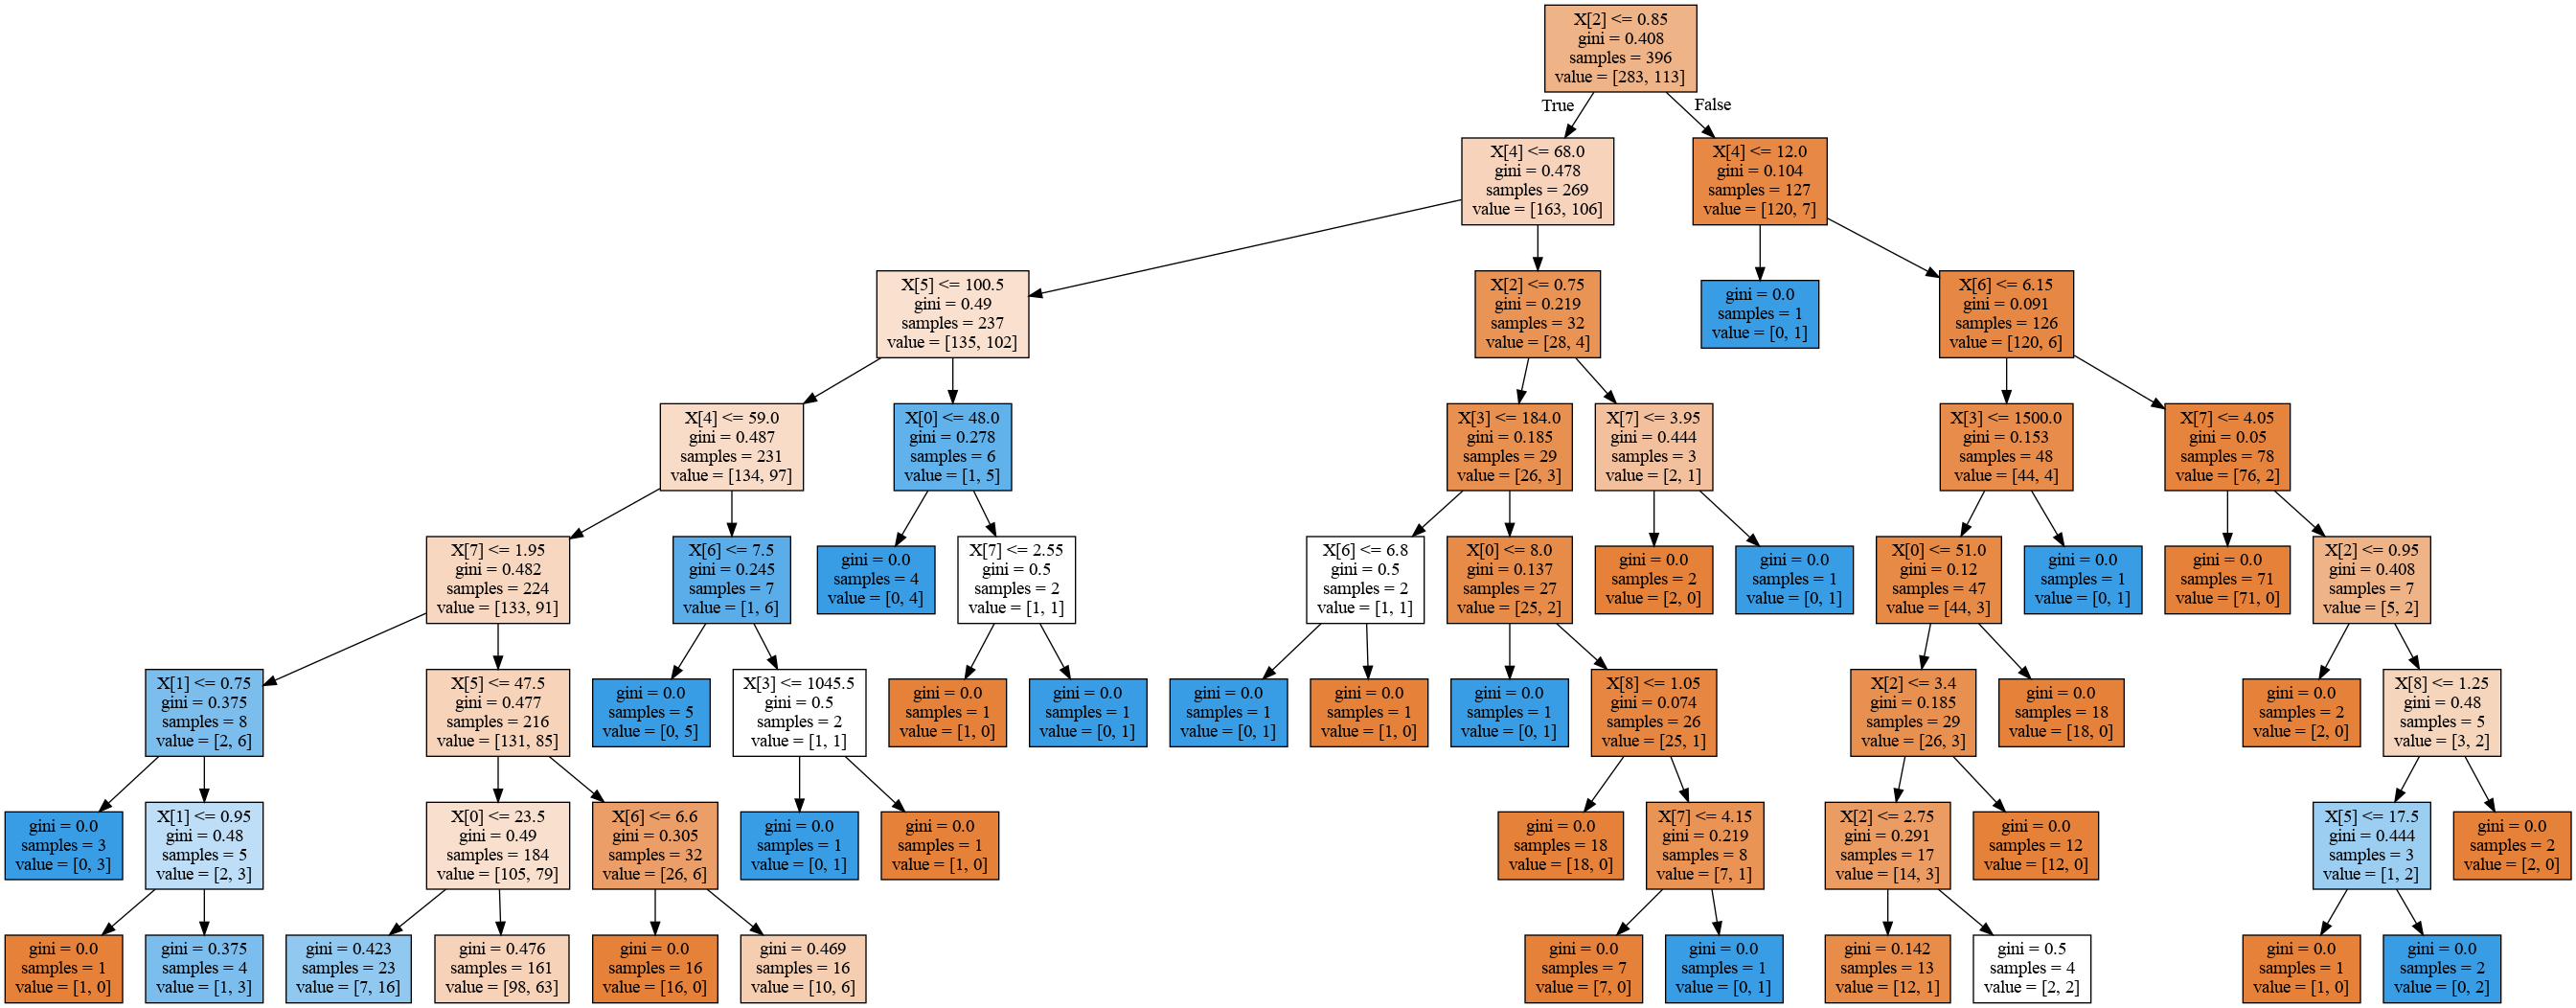

In [40]:
# Visualizing the decision tree

from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(grid_search_DT.best_estimator_, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = "liver_tree.png"
graph.write_png(filename)
Image(filename=filename)

In [42]:
# Ensemble - Bagging or bootstrap aggregating

param_grid = {
    "base_estimator__max_depth": range(1, 101, 10),
    "n_estimators": range(1, 101, 10),
}

grid_search_Bag = GridSearchCV(
    BaggingClassifier(
        base_estimator=DecisionTreeClassifier(
            random_state=42,
        )
    ),
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=25,
)

Bag = grid_search_Bag.fit(X_train_s, y_train)


# Make predictions on the test data
y_pred = grid_search_Bag.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)

print(
    "Best score (precision): \n",
    grid_search_Bag.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_Bag.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_Bag.best_estimator_,
    "\n",
)

Accuracy: 0.7
Precision: 0.46153846153846156
Recall: 0.24489795918367346
F1-Score: 0.32
AUC: 0.5645977399224152
Best score (precision): 
 0.7223333333333335 
 
 Best hyperparameters: 
 {'base_estimator__max_depth': 51, 'n_estimators': 61} 
 
 Best coefficients: 
 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=51,
                                                        random_state=42),
                  n_estimators=61) 



In [43]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

param_grid = {
    "n_estimators": range(1, 101, 10),
    "max_depth": range(1, 101, 10),
    "max_features": ["auto", "sqrt", "log2"],
}

search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy")
search.fit(X_train, y_train)

# Make predictions on the test data
y_pred = search.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)


print(
    "Best score (precision): \n",
    grid_search_DT.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_DT.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_DT.best_estimator_,
    "\n",
)

Accuracy: 0.2823529411764706
Precision: 0.2645161290322581
Recall: 0.8367346938775511
F1-Score: 0.40196078431372556
AUC: 0.4472929667734863
Best score (precision): 
 0.7198333333333333 
 
 Best hyperparameters: 
 {'max_depth': 7, 'max_features': 2} 
 
 Best coefficients: 
 DecisionTreeClassifier(max_depth=7, max_features=2, random_state=42) 



In [44]:
from sklearn.ensemble import ExtraTreesClassifier


model = ExtraTreesClassifier(
    oob_score=True, random_state=42, warm_start=True, bootstrap=True, n_jobs=-1
)

param_grid = {
    "n_estimators": range(1, 101, 10),
    "max_depth": range(1, 101, 10),
    "max_features": ["auto", "sqrt", "log2"],
}

search_ET = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="accuracy")
search_ET.fit(X_train, y_train)

# Make predictions on the test data
y_pred = search_ET.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)


print(
    "Best score (precision): \n",
    search_ET.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    search_ET.best_params_,
    "\n \n",
    "Best coefficients: \n",
    search_ET.best_estimator_,
    "\n",
)

/home/godwin/Desktop/Organised/python/python/ML_Foundation/.venv/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/godwin/Desktop/Organised/python/python/ML_Foundation/.venv/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/godwin/Desktop/Organised/python/python/ML_Foundation/.venv/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/godwin/Desktop/Organised/python/python/ML_Foundation/.venv/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encounte

Accuracy: 0.36470588235294116
Precision: 0.31210191082802546
Recall: 1.0
F1-Score: 0.47572815533980584
AUC: 0.5537190082644627
Best score (precision): 
 0.7274050632911393 
 
 Best hyperparameters: 
 {'max_depth': 11, 'max_features': 'auto', 'n_estimators': 31} 
 
 Best coefficients: 
 ExtraTreesClassifier(bootstrap=True, max_depth=11, n_estimators=31, n_jobs=-1,
                     oob_score=True, random_state=42, warm_start=True) 



In [45]:
from sklearn.ensemble import GradientBoostingClassifier

# The parameters to be fit
tree_list = [15, 25, 50, 100, 200, 400]

param_grid = {
    "n_estimators": tree_list,
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "subsample": [1.0, 0.5],
    "max_features": [1, 2, 3, 4],
}

# The grid search object
GV_GBC = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train_s, y_train)

y_pred = GV_GBC.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)


print(
    "Best score (precision): \n",
    GV_GBC.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    GV_GBC.best_params_,
    "\n \n",
    "Best coefficients: \n",
    GV_GBC.best_estimator_,
    "\n",
)

Accuracy: 0.7
Precision: 0.4583333333333333
Recall: 0.22448979591836735
F1-Score: 0.3013698630136986
AUC: 0.558525889694721
Best score (precision): 
 0.7224050632911392 
 
 Best hyperparameters: 
 {'learning_rate': 0.1, 'max_features': 1, 'n_estimators': 50, 'subsample': 1.0} 
 
 Best coefficients: 
 GradientBoostingClassifier(max_features=1, n_estimators=50, random_state=42) 



In [46]:
from sklearn.ensemble import AdaBoostClassifier

# more affected by outliers compared to gradient boosting
ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=21))

param_grid = {"n_estimators": [100, 150, 200], "learning_rate": [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC, param_grid=param_grid,
                      scoring="accuracy", n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train_s, y_train)

y_pred = GV_ABC.predict(X_test_s)


# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)


# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)


print(
    "Best score (precision): \n",
    GV_ABC.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    GV_ABC.best_params_,
    "\n \n",
    "Best coefficients: \n",
    GV_ABC.best_estimator_,
    "\n",
)

Accuracy: 0.6647058823529411
Precision: 0.4230769230769231
Recall: 0.4489795918367347
F1-Score: 0.43564356435643564
AUC: 0.600522853769607
Best score (precision): 
 0.6540189873417722 
 
 Best hyperparameters: 
 {'learning_rate': 0.01, 'n_estimators': 150} 
 
 Best coefficients: 
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=21),
                   learning_rate=0.01, n_estimators=150) 



Judging from the plot below, decision tree (DT) is the best performing model followed by random forest (RF) and extra random tree (ET)

In [48]:
def measure_error(y_true, y_pred, label):
    return pd.Series(
        {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred),
            "auc": roc_auc_score(y_true, y_pred),
        },
        name=label,
    )


y_pred_logreg = grid_search_logreg.predict(X_test_s)
y_pred_knn = grid_search_KNN.predict(X_test_s)
y_pred_svc = grid_search_SVC.predict(X_test_s)
y_pred_dt = grid_search_DT.predict(X_test_s)
y_pred_bag = grid_search_Bag.predict(X_test_s)
y_pred_rf = search.predict(X_test_s)
y_pred_ET = search_ET.predict(X_test_s)
y_pred_gb = GV_GBC.predict(X_test_s)
y_pred_ad = GV_ABC.predict(X_test_s)


y_train_pred_gr = grid_search_DT.predict(X_train)
y_test_pred_gr = grid_search_DT.predict(X_test)

train_test_gr_error = pd.concat(
    [
        measure_error(y_test, y_pred_logreg, "logreg"),
        measure_error(y_test, y_pred_knn, "knn"),
        measure_error(y_test, y_pred_svc, "svc"),
        measure_error(y_test, y_pred_dt, "dt"),
        measure_error(y_test, y_pred_bag, "bag"),
        measure_error(y_test, y_pred_rf, "rf"),
        measure_error(y_test, y_pred_ET, "ET"),
        measure_error(y_test, y_pred_gb, "gb"),
        measure_error(y_test, y_pred_ad, "ad"),
    ],
    axis=1,
)

train_test_gr_error

,logreg,knn,svc,dt,bag,rf,ET,gb,ad
accuracy,0.729412,0.694118,0.700000,0.288235,0.700000,0.282353,0.364706,0.700000,0.664706
precision,0.600000,0.411765,0.444444,0.288235,0.461538,0.264516,0.312102,0.458333,0.423077
recall,0.183673,0.142857,0.163265,1.000000,0.244898,0.836735,1.000000,0.224490,0.448980
f1,0.281250,0.212121,0.238806,0.447489,0.320000,0.401961,0.475728,0.301370,0.435644
auc,0.567043,0.530106,0.540310,0.500000,0.564598,0.447293,0.553719,0.558526,0.600523


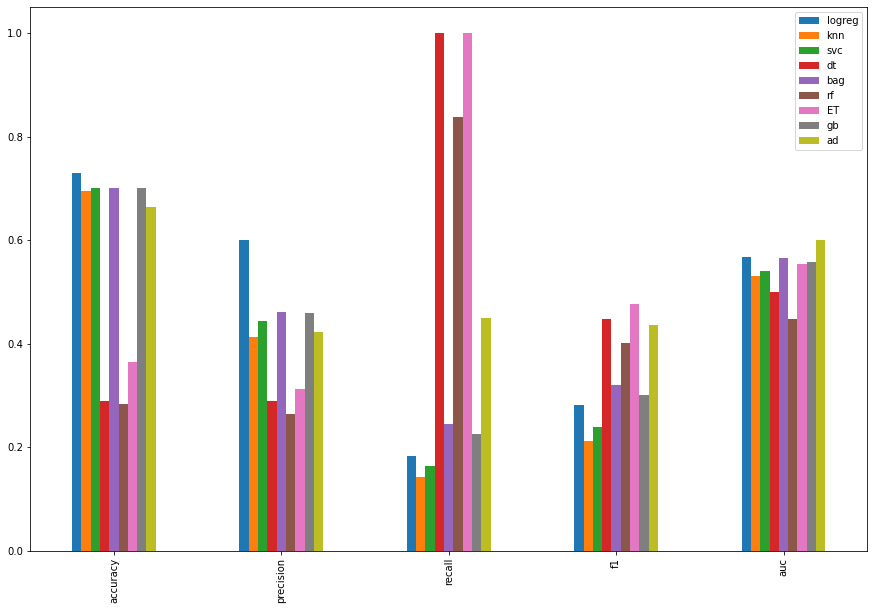

In [56]:
train_test_gr_error.plot(kind="bar", figsize=(15, 10))

## Best Choice Model
Carefully balancing the goal of both interpretability and prediction, the best choice model is the decision tree classier as it has a good AUC, and f1 scores and is also self-interpretable

## Feature importance and Findings
Here, permutation feature importance is used to calculate which features are the most salient towards the prediction and the two most important are the age and total protein is the blood (TP). The relationship between these features and the predicted outcome is shown below to be linear and falling steeply

In [115]:
from sklearn.inspection import permutation_importance, plot_partial_dependence

# Use permutation_importance to calculate permutation feature importances
feature_importances = permutation_importance(
    estimator=grid_search_DT,
    X=X_train_s,
    y=y_train,
    n_repeats=5,
    random_state=42,
    n_jobs=2,
)

(10, 5)


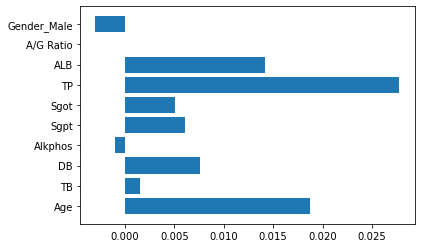

In [116]:
print(feature_importances.importances.shape)
plt.barh(X.columns, feature_importances.importances_mean)
plt.show()

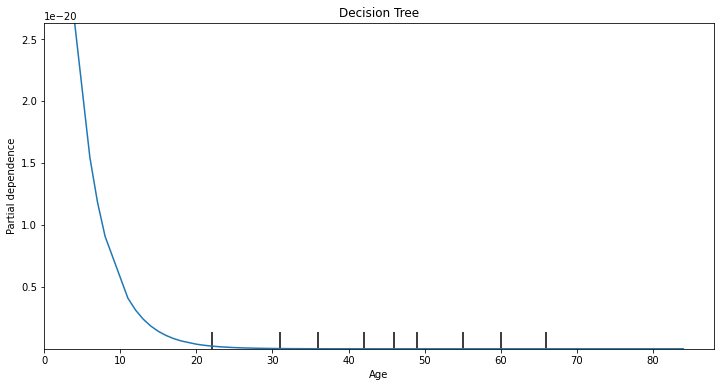

In [129]:
important_features = ["Age"]
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Decision Tree")
plot_partial_dependence(
    estimator=grid_search_DT,
    X=X_train,
    features=important_features,
    random_state=123,
    ax=ax,
)

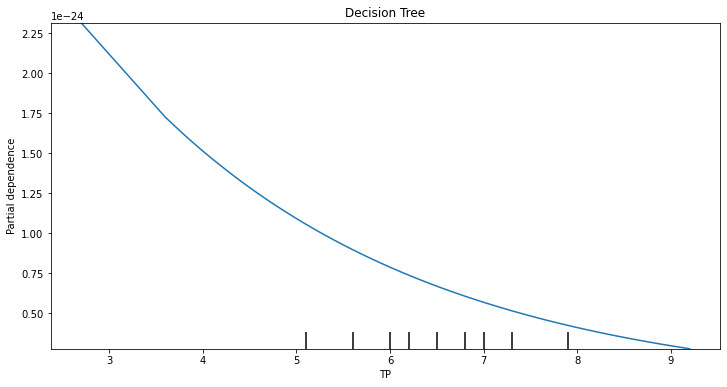

In [130]:
important_features = ["TP"]
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Decision Tree")
plot_partial_dependence(
    estimator=grid_search_DT,
    X=X_train,
    features=important_features,
    random_state=123,
    ax=ax,
)

## Future Steps: Improve Performance of Model
Classifiers are usually built to optimize accuracy and hence will often perform badly on unbalanced classes. To fix the unbalanced class problem, we do either: downamlpling (Tomek link), oversampling (SMOTE), or blagging or collect more data.

Some observation from resampling:
* By oversampling the AUC has impproved marginally by $4\%$ fom the original unbalanced class
* Undersampling increased the AUC score by $1\%$
To improve performance, we first balance the data class

0    0.714646
1    0.285354
Name: Selector_no liver disease, dtype: float64


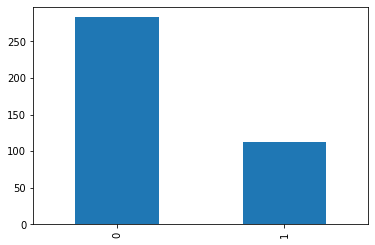

In [67]:
# Visualize the original data befre resampling
y_train.value_counts().plot(kind="bar"),

print(y_train.value_counts(normalize=True))

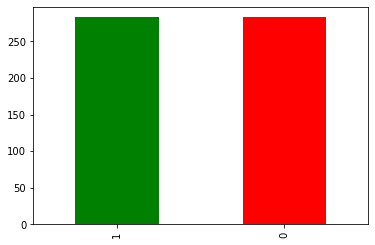

In [63]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

from imblearn.under_sampling import RandomUnderSampler


def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state=123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under


X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

# Visualize over sample classes
y_smo.value_counts().plot.bar(color=["green", "red"])

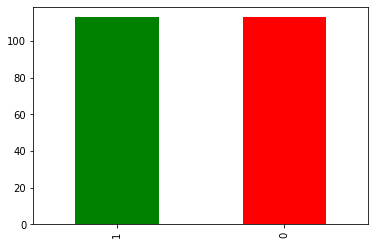

In [65]:
# Visualise under sample class
y_under.value_counts().plot.bar(color=["green", "red"])

In [70]:
# Over sample classes
model_et = DecisionTreeClassifier(max_depth=7, max_features=2, random_state=42)


model_et = model_et.fit(X_smo, y_smo)

# Make predictions on the test data
y_pred = model_et.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)

Accuracy: 0.3411764705882353
Precision: 0.30434782608695654
Recall: 1.0
F1-Score: 0.4666666666666667
AUC: 0.5371900826446281


In [71]:
# Under sampling classes
model_et = ExtraTreesClassifier(
    bootstrap=True,
    max_depth=11,
    n_estimators=31,
    n_jobs=-1,
    oob_score=True,
    random_state=42,
    warm_start=True,
)


model_et = model_et.fit(X_under, y_under)

# Make predictions on the test data
y_pred = model_et.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)

Accuracy: 0.3
Precision: 0.2916666666666667
Recall: 1.0
F1-Score: 0.45161290322580644
AUC: 0.5082644628099173


In [ ]:
# original metrics
# Accuracy: 0.36470588235294116
# Precision: 0.31210191082802546
# Recall: 1.0
# F1-Score: 0.47572815533980584
# AUC: 0.5537190082644627